In [1]:
import pandas as pd
import re
import numpy as np
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dropout
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [2]:
test = pd.read_csv('Fake News/test.csv')
test.head()

,id,title,author,text
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning..."
1,20801,Russian warships ready to strike terrorists ne...,NaN,Russian warships ready to strike terrorists ne...
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different..."
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...


In [3]:
train = pd.read_csv('Fake News/train.csv')
train.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [4]:
test.isnull().sum()

id          0
title     122
author    503
text        7
dtype: int64

In [5]:
train.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [6]:
test.shape, train.shape

((5200, 4), (20800, 5))

In [7]:
train['author'] = train['author'].fillna('missing')
test['author'] = test['author'].fillna('missing')

In [8]:
train = train.dropna()
test = test.dropna()

In [9]:
test.shape, train.shape

((5071, 4), (20203, 5))

In [10]:
df = train.merge(test, how='outer')
df.tail(20)

,id,title,author,text,label
25254,25980,Singers in Russian Military Choir Among 92 Fea...,Ivan Nechepurenko,"SOCHI, Russia — A Russian aircraft bound fo...",NaN
25255,25981,U.S. Near Bottom in Public ‘Confidence in Elec...,Eric Zuesse.,MOST Voters Now Think Clinton Broke the Law … ...,NaN
25256,25982,"After 6,000 Exorcisms, Priest Says ‘The Devil ...","Thomas D. Williams, Ph.D.",A Mexican priest who has performed more than 6...,NaN
25257,25983,WSJ: White House Opens Door to Democrats in Wa...,Breitbart News,With Republicans unable to reach a deal to rep...,NaN
25258,25984,Fox Sports’ Clay Travis Rips ’Hypocritical’ Ni...,Trent Baker,During the Monday version of his Fox Sports Ra...,NaN
25259,25985,"Pillars of the West Shaken by ‘Brexit,’ but Th...",Steven Erlanger,LONDON — On a day that blended dull ritual ...,NaN
25260,25986,The Fed Plans for the Next Crisis,Ron Paul,\nIn her recent address at the Jackson Hole ...,NaN
25261,25987,‘The Market Is Saturated’: Brooklyn’s Rental B...,Charles V. Bagli,From the roof of a building near the Atlantic ...,NaN
25262,25988,"The Dangers of ‘Polypharmacy,’ the Ever-Mounti...",Paula Span,Dr. Caleb Alexander knows how easily older peo...,NaN
25263,25989,Amazon extends olive branch to Megyn Kelly ove...,Staff Writer,11.23.2016 @4:17 PM EST More Establishment tie...,NaN


In [11]:
df.reset_index
df.shape

(25274, 5)

In [12]:
unreliable_count =len(df[df['label']==1])
reliable_count = len(df[df['label']== 0])

In [13]:
unreliable_count

9816

In [14]:
reliable_count

10387

<AxesSubplot:xlabel='Author'>

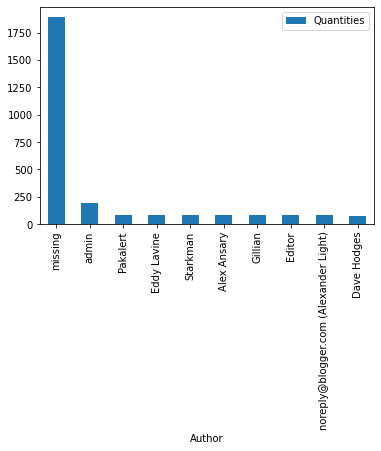

In [15]:
unreliable_author = pd.DataFrame({'Author':df[df['label']==1]['author'].value_counts().head(10).index,
                                  'Quantities':df[df['label']==1]['author'].value_counts().head(10)})

unreliable_author.plot(kind='bar',x='Author',y='Quantities')

<AxesSubplot:xlabel='Author'>

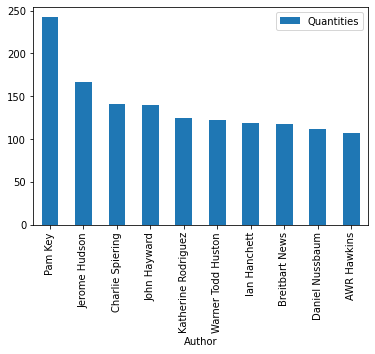

In [16]:
reliable_author = pd.DataFrame({'Author':df[df['label']==0]['author'].value_counts().head(10).index,
                                  'Quantities':df[df['label']==0]['author'].value_counts().head(10)})

reliable_author.plot(kind='bar',x='Author',y='Quantities')

In [17]:
df.isnull().sum()

id           0
title        0
author       0
text         0
label     5071
dtype: int64

In [18]:
messages=df.drop('label', axis=1).copy()
messages.head()

,id,title,author,text
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ..."
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...


In [19]:
wl = WordNetLemmatizer()
corpus = []
for i in range(0, len(messages)):
    
    review = re.sub('[^a-zA-Z]', ' ', messages['title'][i])
    review = review.lower()
    review = review.split()
    
    review = [wl.lemmatize(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)

In [20]:
corpus

['house dem aide even see comey letter jason chaffetz tweeted',
 'flynn hillary clinton big woman campus breitbart',
 'truth might get fired',
 'civilian killed single u airstrike identified',
 'iranian woman jailed fictional unpublished story woman stoned death adultery',
 'jackie mason hollywood would love trump bombed north korea lack trans bathroom exclusive video breitbart',
 'life life luxury elton john favorite shark picture stare long transcontinental flight',
 'beno hamon win french socialist party presidential nomination new york time',
 'excerpt draft script donald trump q ampa black church pastor new york time',
 'back channel plan ukraine russia courtesy trump associate new york time',
 'obama organizing action partner soros linked indivisible disrupt trump agenda',
 'bbc comedy sketch real housewife isi cause outrage',
 'russian researcher discover secret nazi military base treasure hunter arctic photo',
 'u official see link trump russia',
 'yes paid government troll soc

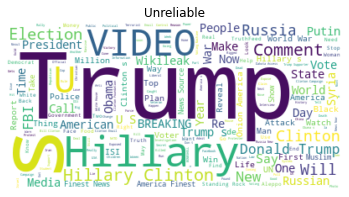

In [21]:
unreliable_wc = WordCloud(background_color = 'white')
unreliable_wc.generate(' '.join(df[df['label']==1]['title']))
plt.imshow(unreliable_wc,interpolation = 'bilinear')
plt.title('Unreliable')
plt.axis('off')
plt.show()

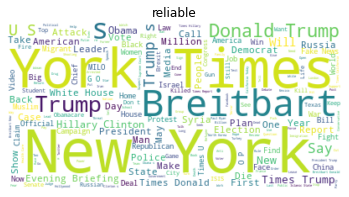

In [22]:
reliable_wc = WordCloud(background_color = 'white')
reliable_wc.generate(' '.join(df[df['label']==0]['title']))
plt.imshow(reliable_wc,interpolation = 'bilinear')
plt.title('reliable')
plt.axis('off')
plt.show()

In [23]:
unreliable_title = train[train['label']==1]['title']
reliable_title = train[train['label']==0]['title']

In [24]:
### Finding most common words 
cw_unreliable = pd.Series(' '.join([str(i) for i in unreliable_title ]).split()).value_counts().head(20).index
cw_reliable = pd.Series(' '.join([str(i) for i in reliable_title ]).split()).value_counts().head(20).index

In [25]:
### deleting common words
common_words = set(cw_unreliable).intersection(cw_reliable)

def text_cleaning(data):
    review = [i for i in data.split() if i not in common_words ]
    return review

In [26]:
common_words

{'-', 'Is', 'The', 'Trump', 'a', 'and', 'for', 'in', 'of', 'on', 'the', 'to'}

In [27]:
test['total'] = test['author'] + test['title']

In [28]:
test = test.drop(columns = ['title','author'])
test.head()

,id,text,total
0,20800,"PALO ALTO, Calif. — After years of scorning...",David StreitfeldSpecter of Trump Loosens Tongu...
1,20801,Russian warships ready to strike terrorists ne...,missingRussian warships ready to strike terror...
2,20802,Videos #NoDAPL: Native American Leaders Vow to...,Common Dreams#NoDAPL: Native American Leaders ...
3,20803,"If at first you don’t succeed, try a different...",Daniel VictorTim Tebow Will Attempt Another Co...
4,20804,42 mins ago 1 Views 0 Comments 0 Likes 'For th...,Truth Broadcast NetworkKeiser Report: Meme War...


In [29]:
def preprocess_data(data):
    
    review = re.sub('[^a-zA-Z]',' ',data) # filtering out miscellaneous text.
    review = review.lower()
    review = review.split()
    review = [wl.lemmatize(words) for words in review if words not in stopwords.words('english') and words.isalpha()]
    review = ' '.join(review)
    return review

In [30]:
test['clean_total'] = test['total'].apply(preprocess_data)

In [31]:
test['clean_total'] = test['clean_total'].apply(text_cleaning)

In [32]:
sentence_length = 25
tokenizer = Tokenizer()
test_total = tokenizer.texts_to_sequences(test['clean_total'])
test_total = pad_sequences(test_total,maxlen = sentence_length)

In [33]:
df['clean'] = corpus

In [34]:
df['clean'] = df['clean'].apply(text_cleaning)

In [35]:
### converting to one hot representation
voc_size = 5000
one_hot_rep = [one_hot(words,voc_size)for words in corpus]
one_hot_rep

[[3206, 2574, 3774, 3151, 4363, 4, 81, 4560, 1347, 1262],
 [3248, 4890, 1754, 3826, 2653, 1555, 966],
 [1338, 1224, 3496, 2141],
 [1225, 3553, 3765, 1812, 4579, 6],
 [1282, 2653, 4946, 1780, 882, 110, 2653, 4567, 2702, 2186],
 [4160,
  1156,
  23,
  4034,
  1685,
  995,
  4011,
  2482,
  2545,
  3895,
  670,
  3854,
  1665,
  1245,
  966],
 [1973, 1973, 1678, 2300, 2280, 2880, 3767, 3641, 918, 3348, 751, 4771],
 [1382, 3344, 4729, 1048, 104, 2461, 1551, 2200, 2985, 1132, 4529],
 [3624, 1736, 2416, 2248, 995, 2162, 1026, 3906, 3181, 1423, 2985, 1132, 4529],
 [2798, 1107, 4562, 1799, 2323, 2311, 995, 3129, 2985, 1132, 4529],
 [140, 4260, 894, 3811, 1434, 2686, 3992, 1708, 995, 2041],
 [3704, 3535, 2144, 4100, 502, 1540, 1114, 524],
 [3551, 1795, 1609, 353, 3180, 1652, 1574, 475, 839, 4131, 4828],
 [1812, 331, 4363, 4910, 995, 2323],
 [3323, 410, 4605, 1507, 1972, 4911, 4969, 3934, 3610],
 [4502, 4000, 4958, 1460, 2614, 4637, 1807, 2985, 1132, 4529],
 [3224, 3709, 3007, 1121, 3449, 2985, 

In [36]:
sent_length=25
embedded_docs = pad_sequences(one_hot_rep, padding='pre', maxlen = sent_length)
print(embedded_docs)

[[   0    0    0 ... 4560 1347 1262]
 [   0    0    0 ... 2653 1555  966]
 [   0    0    0 ... 1224 3496 2141]
 ...
 [   0    0    0 ... 2985 1132 4529]
 [   0    0    0 ... 3551 1428 3317]
 [   0    0    0 ... 2985 1132 4529]]


In [37]:
embedded_docs.shape

(25274, 25)

In [38]:
## Creating model
embedding_vector_features=40
model=Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model.add(Bidirectional(LSTM(100)))
model.add(Dropout(0.3))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 25, 40)            200000    
_________________________________________________________________
bidirectional (Bidirectional (None, 200)               112800    
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 201       
Total params: 313,001
Trainable params: 313,001
Non-trainable params: 0
_________________________________________________________________
None


In [39]:
X = np.array(embedded_docs[:20203])
y = train['label']

In [40]:
X.shape, y.shape

((20203, 25), (20203,))

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [42]:
### Finally Training
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=64)

Epoch 1/10
221/221 [==============================] - 12s 36ms/step - loss: 0.4451 - accuracy: 0.7767 - val_loss: 0.1858 - val_accuracy: 0.9220
Epoch 2/10
221/221 [==============================] - 6s 26ms/step - loss: 0.1359 - accuracy: 0.9438 - val_loss: 0.1859 - val_accuracy: 0.9325
Epoch 3/10
221/221 [==============================] - 6s 26ms/step - loss: 0.0816 - accuracy: 0.9730 - val_loss: 0.2132 - val_accuracy: 0.9307
Epoch 4/10
221/221 [==============================] - 6s 26ms/step - loss: 0.0512 - accuracy: 0.9832 - val_loss: 0.2573 - val_accuracy: 0.9200
Epoch 5/10
221/221 [==============================] - 6s 26ms/step - loss: 0.0281 - accuracy: 0.9912 - val_loss: 0.3223 - val_accuracy: 0.9137
Epoch 6/10
221/221 [==============================] - 6s 27ms/step - loss: 0.0235 - accuracy: 0.9937 - val_loss: 0.3743 - val_accuracy: 0.9228
Epoch 7/10
221/221 [==============================] - 6s 27ms/step - loss: 0.0177 - accuracy: 0.9947 - val_loss: 0.4558 - val_accuracy: 0.912

In [43]:
y_pred = model.predict_classes(X_test)

C:\Users\Sekiro\Anaconda3\envs\work\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [44]:
confusion_matrix(y_test,y_pred)

array([[2868,  276],
       [ 231, 2686]], dtype=int64)

In [45]:
accuracy_score(y_test,y_pred)

0.9163504372215806

In [46]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.93      0.91      0.92      3144
           1       0.91      0.92      0.91      2917

    accuracy                           0.92      6061
   macro avg       0.92      0.92      0.92      6061
weighted avg       0.92      0.92      0.92      6061

